# Traffic Signs detection

## Prerequisites

In [1]:
!pip install tensorflow_hub


In [2]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'tensorflow'

### Output configuration

In [ ]:
OUTPUT_ROOT_DIR = "output/"
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.tflite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")

### Model configuration

In [ ]:
SELECTED_MOBILENET = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

IMAGE_SHAPE = (224, 224)

MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

#Input layer of MobileNet v1 has constant name called "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
#Output layer can be defined by us, default one is "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

## Dataset

Our dataset comes from **GTSRB** - The German Traffic Sign Recognition Benchmark ([website](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), [kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)). It contains more than 40 classes and more than 50,000 images of traffic signs, which are prepared for multi-class, single-image classification challenge. Base on it we'll build simple classifier that can be used in mobile application (or any other TensorFlow Lite project).

In [ ]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [ ]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation    
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:-- 

In [ ]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 7.51 s, sys: 2.77 s, total: 10.3 s
Wall time: 19.4 s


### Prepare training, validation and labels

#### Labels

Originally dataset operates on numerical labels (e.g. "00000"). Let's make it human-readable.  
Labels will be saved in `/output` directory - they can be used together with final TensorFlow Lite model.

In [ ]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()



#### Training dataset preparation

The only tricky part of GTSRB dataset is that images are stored as [*.ppm](https://en.wikipedia.org/wiki/Netpbm_format) files, which aren't supported by TensorFlow by default. To make it possible we need to convert them to .jpg files.

In [ ]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [ ]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 10.7 s, sys: 2.51 s, total: 13.2 s
Wall time: 13.2 s


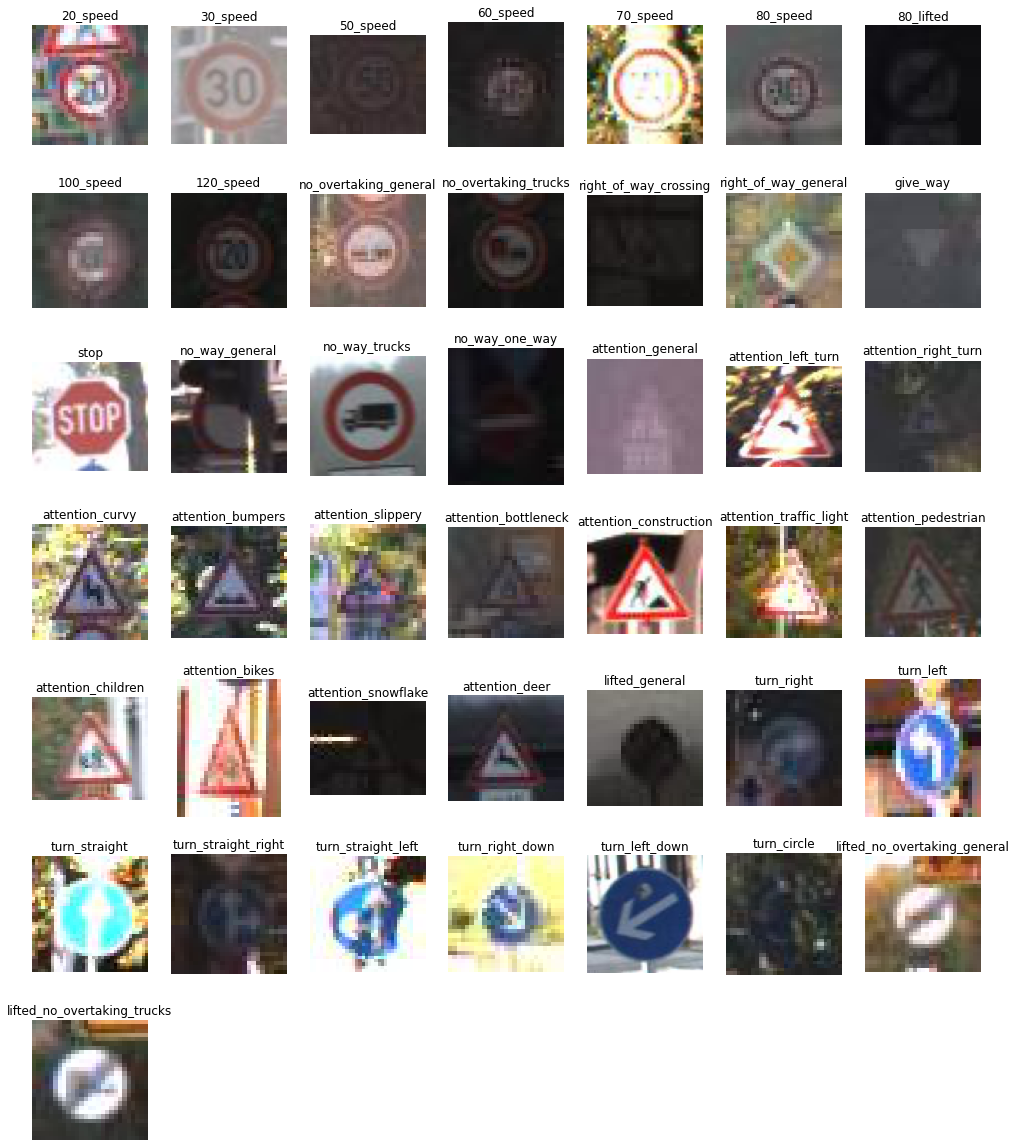

In [ ]:
# Print all categories with example image for each of them.
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.





In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=IMAGE_SHAPE)

Found 39209 images belonging to 43 classes.


The resulting object is an iterator that returns image_batch, label_batch pairs.

In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


#### Validation dataset preparation

Convert also the validation dataset from *.ppm to *.jpg

In [ ]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [ ]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()
    
print("Validation images count:", len(validation_images))

Validation images count: 12630
CPU times: user 5.84 s, sys: 935 ms, total: 6.78 s
Wall time: 6.79 s


## Training

Download a headless model

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [ ]:
feature_extractor_layer.trainable = False

Attach a classification head

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 43)                55083     
Total params: 2,313,067
Trainable params: 55,083
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 43])

### Start training process

Use compile to configure the training process:

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

Start training the network (Hint: In Google Colab use a GPU hardware acceleration for a faster training)

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
 
batch_stats_callback = CollectBatchStats()
 
history = model.fit(image_data, epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/20
1226/1226 [==============================] - 55s 45ms/step - loss: 1.0921 - acc: 0.6250
Epoch 2/20
1226/1226 [==============================] - 55s 45ms/step - loss: 0.5572 - acc: 0.8438
Epoch 3/20
1226/1226 [==============================] - 54s 44ms/step - loss: 0.7452 - acc: 0.7500
Epoch 4/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.5237 - acc: 0.8438
Epoch 5/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.2668 - acc: 0.9062
Epoch 6/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.3991 - acc: 0.9375
Epoch 7/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.5242 - acc: 0.8438
Epoch 8/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.3674 - acc: 0.9062
Epoch 9/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.4550 - acc: 0.8438
Epoch 10/20
1226/1226 [==============================] - 52s 43ms/step - loss: 0.2788 - acc: 0.9375
Epoch 11/

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

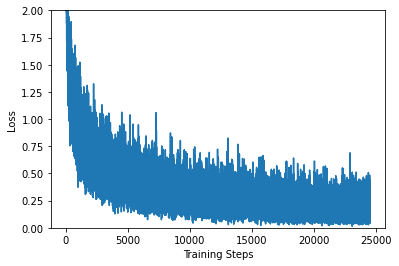

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

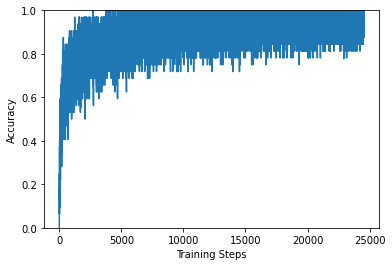

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Model Evaluation



### Transformation of the evaluation dataset

Load the validation data from the CSV file into a pandas data frame. 
Also change the file ending from *.ppm to *.jpg in the `Filename` column.
Then also rescale the values for the model. 
The `ClassId` must be a string and with leading zeros, because this classification naming was also used for the subfolders in the training dataset. 

In [ ]:
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(val_data_frame, x_col="Filename", directory=VALIDATION_DATA_DIR, y_col="ClassId", target_size=IMAGE_SHAPE)

Found 12630 validated image filenames belonging to 43 classes.


In [ ]:
for image_val_batch, label_val_batch in image_val_data:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


### Display some predition result


Run one image batch through the model and extract the predicted traffic sign ID. 


In [ ]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

Display the images in one batch with the prediction result. 
Print the accuracy for the displayed batch. 

Accuracy of the shown eval batch:


0.625

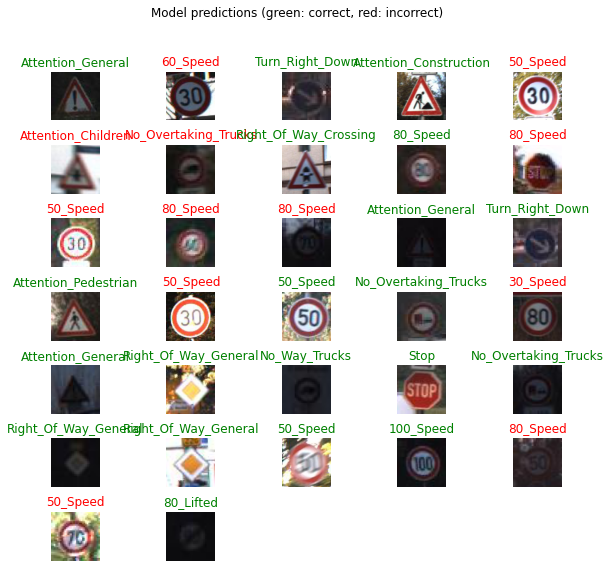

In [ ]:
batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row,num_plot_column,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

print("Accuracy of the shown eval batch:")
accuracy_score(label_id, predicted_id)